In [118]:
MAX_EPOCHS = 1000
BATCH_SIZE = 128
LEARNING_RATE = 0.001
SMILES_COL = 'Column3'
REGRESSION_COL = 'Column62'
URL = '/home/ishii/graduation_research/data/csvファイル/dft_B3LYP_6-31G*_zinc_for-sale_1000000_0to100000.csv'


In [119]:
#regression_col
import torch
import pandas as pd
from collections import Counter

class Dataset(torch.utils.data.Dataset):
    def __init__(self, url, smiles_col, regression_col):
        self.max_length = 0
        self.dummy_char = '_'
        
        self.url = url
        self.smiles_col = smiles_col
        self.smiles = []
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()
        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}
        self.words_indexes = [self.word_to_index[w] for w in self.words]

        self.regression_col = regression_col
        self.regressions = []
        self.items = self.generate_items()
        
        self.dummmy_index = self.word_to_index[self.dummy_char]

    def load_words(self):
        train_df = pd.read_csv(self.url, usecols=[SMILES_COL])
        self.smiles = list(train_df[self.smiles_col])
        for i, smile in enumerate(self.smiles):
            new_smile = smile[1:]
            self.smiles[i] = new_smile
        self.max_length = max(len(smile) for smile in self.smiles)
        self.smiles = list(smile.ljust(self.max_length, self.dummy_char) for smile in self.smiles)
        train_df = pd.Series(self.smiles)
        text = train_df.str.cat(sep=' ')
        text = "".join(text.split(' '))
        return [text[i] for i in range(len(text))]
    
    def generate_items(self):
        train_df = pd.read_csv(self.url, usecols=[REGRESSION_COL])
        self.regressions = list(train_df[self.regression_col])
        items = []
        for i, smile in enumerate(self.smiles):
            smile = list(smile)
            items.append([self.word_to_index[w] for w in smile])
        return items

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.regressions)

    def __getitem__(self, index):
        return (
            torch.tensor(self.items[index]),
            torch.tensor(self.regressions[index])
        )

In [120]:
#変更後のモデル
import torch

class LSTM_Predictor(torch.nn.Module):
    def __init__(self, dataset):
        super(LSTM_Predictor, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = torch.nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
            #padding_idxの処理が不明確
            #padding_idx=dataset.dummmy_index
        )
        self.lstm = torch.nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=0.2,
        )
        self.fc = torch.nn.Linear(self.lstm_size, 1)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)

        return logits, state

    def init_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size),
                torch.zeros(self.num_layers, batch_size, self.lstm_size))

In [121]:
#変更後の訓練プロセス
import torch
import numpy as np

def train(dataset, train_dataset, model):
    losses = []
    val_losses = []
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    for epoch in range(MAX_EPOCHS):
        model.train()
        
        state_h, state_c = model.init_state(BATCH_SIZE)
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        total_loss = 0
        total_val_loss = 0

        for batch, (x, y) in enumerate(train_dataloader):
            if batch < int(len(train_dataloader) * 0.75):
                model.train()
                
                optimizer.zero_grad()
                
                y_pred, (state_h, state_c) = model(x.to(device), (state_h, state_c))
                y_pred_permute = torch.permute(y_pred, (2, 1, 0))
                loss = criterion(y_pred_permute[0][dataset.max_length-1], y.to(device))
                total_loss += loss.item()

                state_h = state_h.detach()
                state_c = state_c.detach()

                loss.backward()
                optimizer.step()
                
            else:
                model.eval()
                
                y_pred, (state_h, state_c) = model(x.to(device), (state_h, state_c))
                y_pred_permute = torch.permute(y_pred, (2, 1, 0))
                val_loss = criterion(y_pred_permute[0, dataset.max_length-1], y.to(device))
                total_val_loss += val_loss.item()    
                
                state_h = state_h.detach()
                state_c = state_c.detach()
        
        #scheduler.step()
        
        average_total_loss = total_loss / int(len(train_dataloader) * 0.75)
        average_total_val_loss = total_val_loss / (len(train_dataloader) - int(len(train_dataloader) * 0.75))
        
        print("Epoch: {}, train_Loss: {}, val_Loss: {}".format(
            epoch+1, 
            average_total_loss,
            average_total_val_loss
        ))
        losses.append(average_total_loss)
        val_losses.append(average_total_val_loss)
    return losses, val_losses

In [122]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device: " + str(device) + '\n')


device: cuda:0



In [123]:
dataset = Dataset(url=URL, smiles_col=SMILES_COL, regression_col=REGRESSION_COL)
n_samples = len(dataset)
indices = list(range(n_samples))
train_size = int(n_samples * 0.8)
test_size = n_samples - train_size

train_dataset = torch.utils.data.Subset(dataset, indices[:train_size])
test_dataset = torch.utils.data.Subset(dataset, indices[train_size:])

print(len(train_dataset))
print(len(test_dataset))


70102
17526


In [124]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)
print(int(len(train_dataloader) * 0.75))
print(len(train_dataloader) - int(len(train_dataloader) * 0.75))

410
137


In [125]:
model = LSTM_Predictor(dataset)
model = model.to(device)
train_losses, val_losses = train(dataset, train_dataset, model)

Epoch: 1, train_Loss: 1.8425041694466662, val_Loss: 1.748183159932603
Epoch: 2, train_Loss: 1.7922110902100075, val_Loss: 1.7260797023773193
Epoch: 3, train_Loss: 1.7916952223312563, val_Loss: 1.7184006732745762
Epoch: 4, train_Loss: 1.7916504896268612, val_Loss: 1.7178025019429897
Epoch: 5, train_Loss: 1.7917918138387727, val_Loss: 1.718350705439157
Epoch: 6, train_Loss: 1.792154639668581, val_Loss: 1.7198387775978032
Epoch: 7, train_Loss: 1.7926581356583573, val_Loss: 1.722067413538912
Epoch: 8, train_Loss: 1.793400623304088, val_Loss: 1.7230114201559639
Epoch: 9, train_Loss: 1.7942836557946553, val_Loss: 1.722449253945455
Epoch: 10, train_Loss: 1.795098170710773, val_Loss: 1.7215928291752391
Epoch: 11, train_Loss: 1.795542931992833, val_Loss: 1.7212268296819533
Epoch: 12, train_Loss: 1.7957218869430263, val_Loss: 1.7210253690281054
Epoch: 13, train_Loss: 1.7958239443418456, val_Loss: 1.7209066013350105
Epoch: 14, train_Loss: 1.7958706549028072, val_Loss: 1.720828384813601
Epoch: 15,

In [133]:
def predect(dataset, test_dataset, model):
    model.eval()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=5, drop_last=True)

    index = np.random.choice(len(test_dataloader))
    
    for batch, (x, y) in enumerate(test_dataloader):
    
        smiles, wavelength = x, y
        break
    state_h, state_c = model.init_state(5)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    y_pred, (state_h, state_c) = model(smiles.to(device), (state_h, state_c))
    y_pred_permute = torch.permute(y_pred, (2, 1, 0))    

    print(y_pred_permute)
    print(wavelength)

In [127]:
predect(dataset, test_dataset, model)

tensor([[[-0.0726, -0.1839, -0.1839, -0.1839, -0.1839],
         [-0.1162, -0.5293, -0.7402, -0.5293, -0.5293],
         [-0.2724, -1.0068, -1.3992, -1.0068, -1.1366],
         [-0.5556, -1.4714, -1.7319, -1.4714, -1.6050],
         [-1.0207, -1.7217, -1.8202, -1.7217, -1.7867],
         [-1.4371, -1.8110, -1.8385, -1.8110, -1.8313],
         [-1.6880, -1.8355, -1.8421, -1.8355, -1.8406],
         [-1.7950, -1.8413, -1.8428, -1.8413, -1.8425],
         [-1.8289, -1.8426, -1.8430, -1.8426, -1.8429],
         [-1.8391, -1.8429, -1.8430, -1.8429, -1.8430],
         [-1.8420, -1.8430, -1.8430, -1.8430, -1.8430],
         [-1.8427, -1.8430, -1.8430, -1.8430, -1.8430],
         [-1.8429, -1.8430, -1.8430, -1.8430, -1.8430],
         [-1.8430, -1.8430, -1.8430, -1.8430, -1.8430],
         [-1.8430, -1.8430, -1.8430, -1.8430, -1.8430],
         [-1.8430, -1.8430, -1.8430, -1.8430, -1.8430],
         [-1.8430, -1.8430, -1.8430, -1.8430, -1.8430],
         [-1.8430, -1.8430, -1.8430, -1.8430, -1

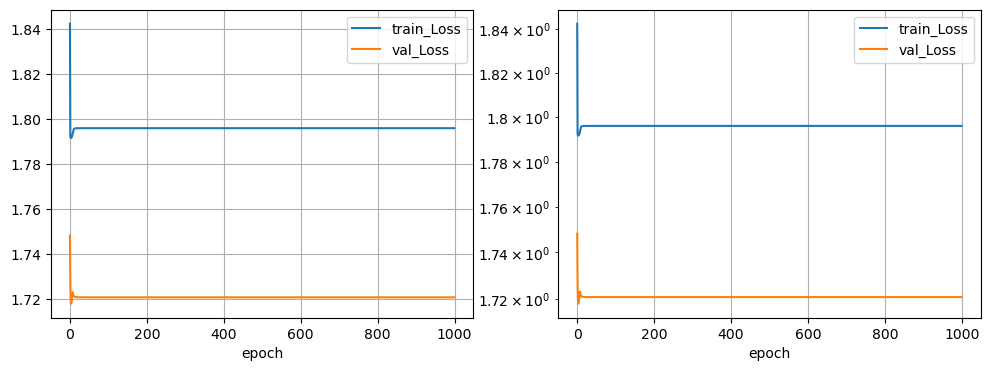

In [134]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(train_losses, label="train_Loss")
axes[0].plot(val_losses, label="val_Loss")
axes[0].grid()
axes[0].set_xlabel("epoch")
axes[0].legend()


axes[1].plot(train_losses, label="train_Loss")
axes[1].plot(val_losses, label="val_Loss")
axes[1].grid()
axes[1].set_yscale('log')
axes[1].set_xlabel("epoch")
axes[1].legend()

plt.show()

In [135]:
def test(dataset, test_dataset, model):
    model.eval()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    batch_size = 1
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, drop_last=True)
    
    criterion = torch.nn.L1Loss()
    
    total_loss = 0
    state_h, state_c = model.init_state(batch_size)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    
    for batch, (x, y) in enumerate(test_dataloader):
    
        y_pred, (state_h, state_c) = model(x.to(device), (state_h, state_c))
        y_pred_permute = torch.permute(y_pred, (2, 1, 0))    
        loss = criterion(y_pred_permute[0, dataset.max_length-1], y.to(device))
        total_loss += loss.item()

        state_h = state_h.detach()
        state_c = state_c.detach()
    
    average_total_loss = total_loss / len(test_dataloader)
    
    return average_total_loss
        

In [136]:
print("test_Loss: {:.3f}".format(test(dataset, test_dataset, model)))

test_Loss: 1.019


In [131]:
model.eval()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

y_list = []
y_pred_list = []

batch_size = 1

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

state_h, state_c = model.init_state(batch_size)
state_h = state_h.to(device)
state_c = state_c.to(device)

for batch, (x, y) in enumerate(test_dataloader):

    y_pred, (state_h, state_c) = model(x.to(device), (state_h, state_c))
    y_pred_permute = torch.permute(y_pred, (2, 1, 0))    
    state_h = state_h.detach()
    state_c = state_c.detach()
    
    y_list.append(y.cpu().detach().numpy())
    y_pred_list.append(y_pred_permute[0, dataset.max_length-1].cpu().detach().numpy())

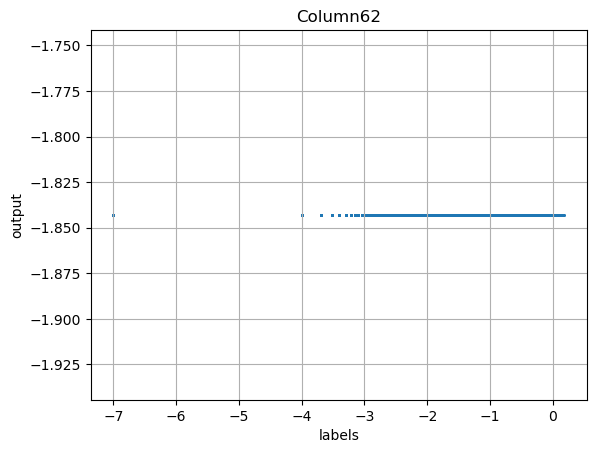

: 

In [138]:

import matplotlib.pyplot as plt
plt.scatter(y_list, y_pred_list, s=1)
plt.title(REGRESSION_COL)
plt.xlabel("labels")
plt.ylabel("output")
plt.grid(True)

plt.show()